**STEP 1: Simulation**

In [1]:
import numpy as np
def generate_heterogeneous_data(w2,mu_2,n, p, imbalance_factor=10, random_seed=39):
    np.random.seed(random_seed)
    
    # Parameters for two components
    # Component 1: Standard variance, centered at 0
    mu1 = np.zeros(p)
    sigma1 = np.eye(p)
    
    # Component 2: High variance, shifted mean and scaled covariance
    mu2 = np.ones(p) * mu_2  # Shifted mean
    sigma2 = np.eye(p) * imbalance_factor  # High variance component
    
    # Define mixing proportions (say, 80% from component 1 and 20% from component 2)
    weights = [1-w2, w2]
    
    # Generate data for each component
    n1 = int(n * weights[0])
    n2 = n - n1
    X1 = np.random.multivariate_normal(mu1, sigma1, size=n1)
    X2 = np.random.multivariate_normal(mu2, sigma2, size=n2)
    
    # Combine the data
    X = np.vstack((X1, X2))
    np.random.shuffle(X)
    epsilon = np.random.normal(0, 1, size=n)
    beta = np.random.normal(0, 1, size=p)
    Y = np.dot(X, beta) + epsilon
    return X, Y, beta

# Example usage
n = 8192       # number of rows         
p = 1000        # number of columns
w2 = 0.33      # weight of the second component
mu_2 = 5       # mean of the second component
imbalance_factor = 10 # imbalance factor for the second component
random_seed = 39 # random seed for reproducibility
X, Y, beta = generate_heterogeneous_data(w2, mu_2, n, p, imbalance_factor, random_seed)

**Step 2: SVD, then plot singular values**

Matplotlib is building the font cache; this may take a moment.


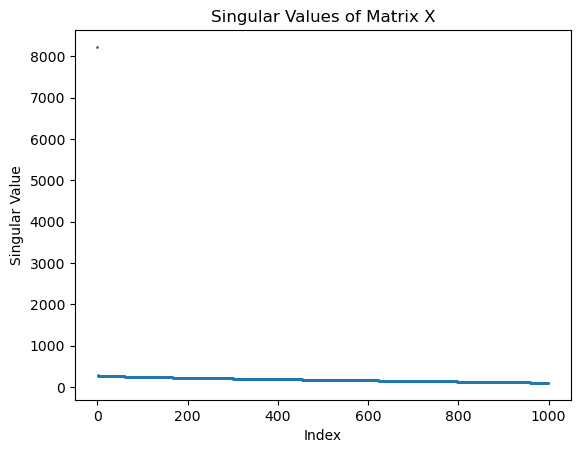

In [2]:
import matplotlib.pyplot as plt

# Compute singular values
U, s, Vh = np.linalg.svd(X)

# Sort singular values in descending order
# s_sorted = np.sort(s)[::-1]

# Plot singular values using a dot plot
plt.scatter(range(len(s)), s,s = 1)
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.title('Singular Values of Matrix X')
plt.show()

**Step 3: Define functions for calculating ratio and norms**

In [3]:
def calculate_the_norm_square(A, b, x_selected):
    A = np.array(A)
    x_selected = np.array(x_selected)
    return np.sum((np.dot(A, x_selected) - b) ** 2)
def error_ratio(A,b,x_hat_bar,x_star):
    return (calculate_the_norm_square(A,b,x_hat_bar) - calculate_the_norm_square(A,b,x_star)) / calculate_the_norm_square(A,b,x_star)

**Step 4: Solve for X_star**

In [4]:
def solver(A,b):
    A = np.array(A)
    b = np.array(b)
    x_star = np.linalg.inv(A.T@A)@A.T@b
    return x_star
x_star = solver(X,Y)
norm_star = calculate_the_norm_square(X,Y,x_star)
print("The norm square of x_star calculated are:")
print(norm_star)

The norm square of x_star calculated are:
6991.2200383235195


**STEP 5: Uniform Sampling sketch // Algorithm 1: Distributed Randomized Regression**

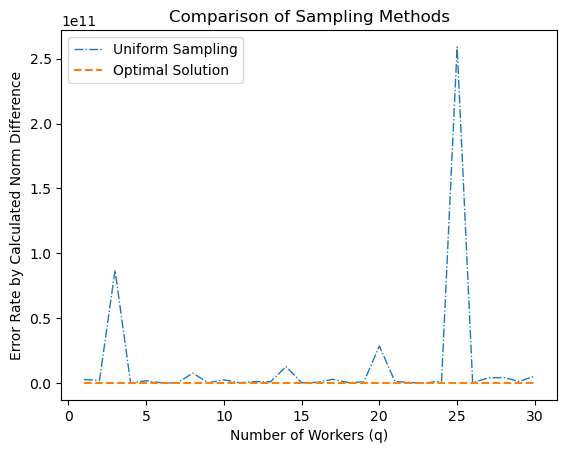

In [5]:
# e.g. our desired sketching size is m = 819 = [8192/10]
m = int(n/10)
# Algorithm 1 inserting inside uniform sampling: Distributed Randomized Regression

# S_k @ A here is just computed as A [uniformly_sampled_index]
# As S_k here is just a diagnoal matrix of 1 or 0 where sampled rows have 1 as value
def uniform_sampling_1(X,Y,n,m,q):
    X = np.array(X)
    Y = np.array(Y)
    x_hat_list = []
    for k in range(q):
        index = np.random.choice(n, size=m, replace=False)
        X_sk = X[index]
        Y_sk = Y[index]
        x_hat = np.linalg.inv(X_sk.T@X_sk)@X_sk.T@Y_sk
        x_hat_list.append(x_hat)
    x_bar = sum(x_hat_list) / q
    return x_bar
import matplotlib.pyplot as plt
# Calculate the error rate for each method
error_uniform = []
error_star = np.zeros((30,1))
for q in range(1, 31):  # adjust the range as needed
    x_bar_uniform = uniform_sampling_1(X, Y, n, m, q)
    error = error_ratio(X, Y, x_bar_uniform, x_star)
    error_uniform.append(error)  # uniform sampling error

# Create the plot
plt.plot(range(1, 31), error_uniform, label='Uniform Sampling',linestyle = '-.',linewidth = 1)
plt.plot(range(1, 31), error_star, label='Optimal Solution', linestyle='--')

plt.xlabel('Number of Workers (q)')
plt.ylabel('Error Rate by Calculated Norm Difference')
plt.title('Comparison of Sampling Methods')
plt.legend()
plt.show()

**Step 6: Now let us explore Fast Hadamard Transform to speed up the hadamard transformation.**<br>
* O(n^2) to O(n*log(n)) *

In [6]:
# Algorithm 1 inserting inside hadamard rademacher randomization: Distributed Randomized Regression

# Step 1: Hadamard rademacher randomization
from math import sqrt
import torch
import spyrit.core.torch as st
def fhm(X,Y):
    # generate an diagonal matrix of -1 or 1 with 0.5 probability
    diag_matrix = np.diag(np.random.choice([-1, 1], size=X.shape[0]))
    signs = diag_matrix
    # multiply each row of X and Y by the corresponding sign
    result_X = np.dot(signs, X)
    result_Y = np.dot(signs, Y)
    # Convert to PyTorch tensor
    tensor_matrix_X = torch.tensor(result_X,dtype = torch.float32)
    tensor_matrix_Y = torch.tensor(result_Y,dtype = torch.float32)
    # Apply FWHT to the entire matrices
    tensor_matrix_X = st.fwht(tensor_matrix_X.T).T
    tensor_matrix_Y = st.fwht(tensor_matrix_Y)
    # Convert back to numpy array
    X = tensor_matrix_X.numpy()/sqrt(X.shape[0])
    Y = tensor_matrix_Y.numpy()/sqrt(Y.shape[0])
    return X,Y

ModuleNotFoundError: No module named 'torch'

In [ ]:
X_hada,Y_hada = fhm(X,Y)

In [ ]:
# Step 2: Uniform sampling on the Hadamard transformed X
def Hadamard_Randomized_Sampling_1(X, Y, n, m, q):
    X = np.array(X)
    Y = np.array(Y)
    X, Y = fhm(X, Y)
    x_hat_list = []
    for k in range(q):
        index = np.random.choice(n, size=m, replace=False)
        X_sk = X[index]
        Y_sk = Y[index]
        x_hat = np.linalg.inv(X_sk.T @ X_sk) @ X_sk.T @ Y_sk
        x_hat_list.append(x_hat)
    x_bar = sum(x_hat_list) / q
    return x_bar

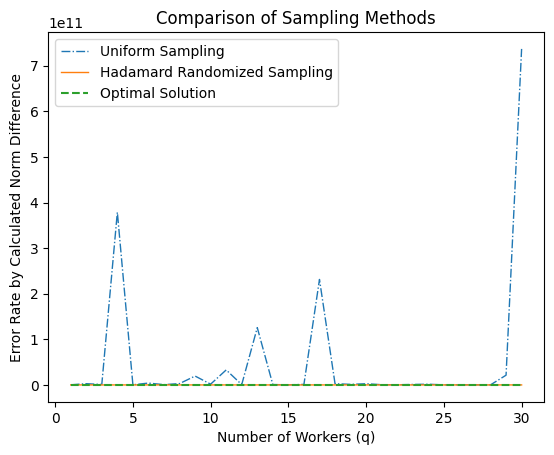

In [ ]:
# Calculate the error rate for each method
error_uniform = []
error_hadamard = []
error_star = np.zeros((30,1))

# Calculate the error rate for each method
for q in range(1, 31):  # adjust the range as needed
    x_bar_uniform = uniform_sampling_1(X, Y, n, m, q)
    x_bar_hadamard = Hadamard_Randomized_Sampling_1(X, Y, n, m, q)
    error_uniform_value = error_ratio(X, Y, x_bar_uniform, x_star)
    error_hadamard_value = error_ratio(X, Y, x_bar_hadamard, x_star)
    error_uniform.append(error_uniform_value)  # uniform sampling error
    error_hadamard.append(error_hadamard_value)
# Create the plot
plt.plot(range(1, 31), error_uniform, label='Uniform Sampling',linestyle = '-.',linewidth = 1)
plt.plot(range(1, 31), error_hadamard, label='Hadamard Randomized Sampling',linestyle = '-',linewidth = 1)
plt.plot(range(1, 31), error_star, label='Optimal Solution', linestyle='--')

plt.xlabel('Number of Workers (q)')
plt.ylabel('Error Rate by Calculated Norm Difference')
plt.title('Comparison of Sampling Methods')
plt.legend()
plt.show()